In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

In [2]:
N = 100
T = 30

U_true = np.random.randn(N, 5)
V_true = np.random.randn(T, 5)

R_true = U_true @ V_true.T + 0.01 * np.random.randn(N, T)

print(R_true)

C = 4 * np.ones(T)

[[ 0.34582277 -1.48686834 -0.52646266 ...  0.33121651  0.21490165
  -0.45323553]
 [-0.16260059 -0.96490251  2.05962053 ... -1.91965594 -0.07172494
   0.11926431]
 [-0.33509285 -3.79506652 -2.00766709 ... -1.98456911  1.28361733
  -0.69706395]
 ...
 [-1.05076266 -5.08132001 -0.04812508 ... -3.45716046  1.730974
  -0.39386376]
 [-1.86592286 -0.78670776 -3.65015204 ... -0.97295903  1.87291805
   0.66446028]
 [ 2.27648206 -1.61457603  3.74607507 ... -1.35614907 -1.82645531
  -0.48276732]]


In [3]:
def solving_system(R, C, reg=1e-5):
    N, T = R.shape
    A1 = np.zeros((N, N * T))
    for i in range(N):
        A1[i, i * T:(i + 1) * T] = np.ones((T))

    A2 = np.zeros((T, N * T))
    for i in range(T):
        A2[i, i:N * T:T] = np.ones((N))
      
    A = np.concatenate((A1, A2, -1 * np.identity(N * T)))
    
    c = -1 * R.reshape((N * T, 1))

    b = np.concatenate((np.ones(N), C, np.zeros(N * T)))
      
    P = reg * np.identity(N * T)
    solvers.options['show_progress'] = False
    sol = solvers.qp(matrix(P, tc='d'), matrix(c, tc='d'), matrix(A, tc='d'), matrix(b, tc='d'))
    x_sys = np.array(sol['x']).reshape((N, T))
    q_sys = np.array(sol['z'])
    return x_sys, q_sys

In [4]:
x, q = solving_system(R_true, C)

4
357.801128515949


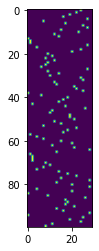

In [5]:
x = np.int32(x > 0.5)
plt.imshow(x)
print(np.max(np.sum(x, axis=0)))
print(np.sum(x * R_true))

14.0
391.65777377032987


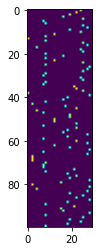

In [6]:
max_ind = np.argmax(R_true, axis=1)
x_without_C = np.zeros((N, T))
x_without_C[np.arange(N), max_ind] = 1
plt.imshow(x_without_C)
print(np.max(np.sum(x_without_C, axis=0)))
print(np.sum(x_without_C * R_true))

In [7]:
sigma = 1
sigma_u = 1
sigma_v = 1
k = 5

def update_UV(observations, U, V, Sigma_U, Sigma_V):

    iter = 0
    
    while True:
        U_prev = U.copy()
        for i in range(N):
            Sigma_sum = 0
            mean_sum = 0
            for obs in observations:
                if obs[0] == i:
                    Sigma_sum += Sigma_V[obs[1]] + np.outer(V[obs[1]], V[obs[1]])
                    mean_sum += obs[2] * V[obs[1]]
            Sigma_U[i] = np.linalg.inv(1/sigma**2 * Sigma_sum + 1/sigma_u**2 * np.identity(k))
            U[i] = Sigma_U[i] @ mean_sum / sigma**2

        for j in range(T):
            Sigma_sum = 0
            mean_sum = 0
            for obs in observations:
                if obs[1] == j:
                    Sigma_sum += Sigma_U[obs[0]] + np.outer(U[obs[0]], U[obs[0]])
                    mean_sum += obs[2] * U[obs[0]]
            Sigma_V[j] = np.linalg.inv(1/sigma**2 * Sigma_sum + 1/sigma_v**2 * np.identity(k))
            V[j] = Sigma_V[j] @ mean_sum / sigma**2
        
        iter += 1
        if np.linalg.norm(U - U_prev) < 1e-2 or iter > 100:
            break
    
    return U, V, Sigma_U, Sigma_V

In [8]:
is_mask_feasible = False
while not is_mask_feasible:
    initial_mask = np.zeros((N, T))
    for i in range(N):
        j = np.random.choice(T)
        initial_mask[i, j] = 1

    if np.min(np.sum(initial_mask, axis=0)) > 0:
        is_mask_feasible = True
        
observations = []
for i in range(N):
    for j in range(T):
        if initial_mask[i, j] == 1:
            observations.append((i, j, R_true[i, j] + np.random.randn()))

In [9]:
Sigma_U = np.stack([np.identity(k) for _ in range(N)], axis=0)
Sigma_V = np.stack([np.identity(k) for _ in range(T)], axis=0)
U = np.random.randn(N, k)
V = np.random.randn(T, k)

In [10]:
horizon = 100

history = np.zeros(horizon)

for t in range(horizon):

    U, V, Sigma_U, Sigma_V = update_UV(observations, U, V, Sigma_U, Sigma_V)
    R_UCB = np.zeros((N,T))

    for i in range(N):
        for j in range(T):
            R_UCB[i,j] = U[i] @ V[j] + 1 * np.sqrt(np.trace(Sigma_U[i].T @ Sigma_V[j] + Sigma_U[i].T @ np.outer(V[j], V[j]) + np.outer(U[i], U[i]) @ Sigma_V[j]))

    x_UCB, _ = solving_system(R_UCB, C)
    x_UCB = np.int32(x_UCB > 0.5)

#     plt.imshow(x_UCB)
#     plt.show()
    print(np.max(np.sum(x_UCB, axis=0)))
    print(np.sum(x_UCB, axis=0))
    print(np.sum(x_UCB * R_true))
    
    history[t] = np.sum(x_UCB * R_true)

    for i in range(N):
        for j in range(T):
            if x_UCB[i, j] == 1:
                observations.append((i, j, R_true[i, j] + np.random.randn()))

6
[4 0 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 0 4 0 4 4 4 4 0 6]
53.29186922921727
4
[4 0 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 0 0]
86.72154197211887
4
[4 1 4 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 2 0]
110.8777688911232
4
[3 0 4 4 4 1 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 3 0]
121.6202316088299
4
[3 0 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 0 0]
123.49009086192316
4
[4 0 4 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 3 0]
145.6769385705563
4
[4 0 4 4 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 2 4 4 4 4 3 0]
209.738883566443
4
[2 0 4 3 4 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 0]
222.50982401026846
4
[1 0 4 0 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 0]
281.4832594609514
4
[2 0 4 1 4 3 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 0]
277.97114697690455
4
[4 1 4 0 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 0 4 4 4 4 4 0]
292.61388594140226
4
[3 4 4 0 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 1 4 4 4 4 4 0]
297.05230569933167
4
[4 4 4 0 4

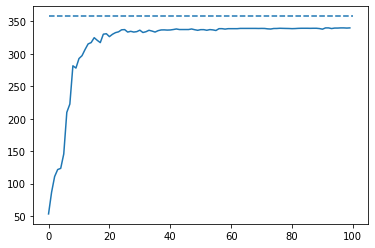

In [15]:
plt.plot(history)
plt.hlines(np.sum(x * R_true), 0, horizon, linestyles='dashed')